In [84]:
## (optional) Run the code below and refresh to get the desired theme in browser
pip install jupyterthemes
!jt -t grade3 -fs 12 -altp -tfs 12 -nfs 12 -ofs 11 -cellw 88% -T 

Author: Yun (Erin) You

## Credit Risk Prediction with Machine Learning

The dataset used in this project is provided by Home Credit and can be found on _kaggle.com_. Home Credit aims to increase financial inclusion for the unbanked population who are unable to get loans through traditional credit scoring system due to lack of credit history. By leveraging a variaty of data sources besides Credit Bureau, Home Credit is able to predict repayment abilities for the unbanked individuals and therefore make credit decisioning based on the predictions.

##### Load libraries

In [111]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve


pd.set_option('display.max_columns', 150)
plt.style.use('seaborn-bright')
%matplotlib inline

### 1. Data Import & Inspection

In [3]:
df = pd.read_csv('application_train.csv')
print("This dataset has {0} rows and {1} columns.".format(df.shape[0], df.shape[1]))
df.head()

This dataset has 307511 rows and 122 columns.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

#### 1.1 Summary Statistics

In [4]:
print('Number of variables by data type: ')
print(df.dtypes.value_counts())

Number of variables by data type: 
float64    65
int64      41
object     16
dtype: int64


Among the 122 variables, `KS_ID_CURR` is the unique ID for loan application, and `TARGET` is the response (1 = default, 0 = paid). Other variables contain applicants' information such as  gender, age, income, assets ownership, education, neighborhood, number of inquiries, and so on. 

The four variables seem interesting according to the summary table below: `DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_REGISTRATION`, and `DAYS_ID_PUBLISH`. They all represent time (in days) of some event relative to the application date, so it would make sense if all of the values on these variables are less than or equal to 0. However, notice that `DAYS_EMPLOYED` has a value of 365243 on some records. Since 365243 is the only positive value in the variable, my guess is that it is intended as a special value when the actual value is unavailable.

In [5]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

Text(0.5, 0, 'Number of Days Relative to Application Date')

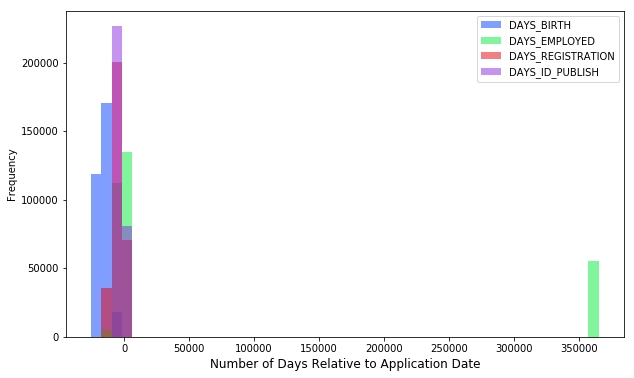

In [25]:
df[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']].plot.hist(bins=50, figsize=(10,6), alpha=0.5)
plt.xlabel('Number of Days Relative to Application Date', fontsize=12)

#### 1.2 Missing Values

The table below shows how many missing values there are for each variable (only shows top 50). There are 40 variables that have more than 50% of the values missing, for which the reasons of missing are unknown. According to the variable names, these variables are related to the characteristics of houses or apartments. 

For modeling purposes, if the algorithm of chosen does not allow missing values, then imputing the missing values becomes necessary. Choosing which method for imputation is a case-by-case problem. Usually for numeric variables, I would try replacing missing values with the mean or median value of the target variable, removing the rows with missing values, or even dropping that variable if the missing rate is too high. When dealing with missing values, one should also keep in mind that if the values are missing in a pattern, then perhaps creating a special value for the missing would be a good idea. 

In [6]:
def null_table(df):
        # Total and percent of missing values
        null_val = df.isnull().sum()
        null_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Create a table with the results
        null_val_table = pd.concat([null_val, null_val_percent], axis = 1).\
                         rename(columns = {0 : '# of Missing', 1 : '% of Missing'}).\
                         sort_values('% of Missing', ascending = False).round(1)
        
        # Return the dataframe with missing information
        return null_val_table

In [7]:
tab1 = null_table(df)

In [15]:
#def display_(d): 
#    pd.set_option("display.max_rows", None) 
#    from IPython.core.display import display 
#    display(d)
#display_(tab1)
tab1.head(50)

,# of Missing,% of Missing
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4


#### 1.3 Set Aside Test Data

In order to know how a model generalizes on any new data, I will take a sample from the data set and use it only for out-of-sample evaluation, i.e., training the model without these records. If the test data is 'seen' before the out-of-sample evaluation, we might end up underestimating the error rate. To reduce sampling bias, I'll use stratified sampling on the response variable `TARGET`.  

In [27]:
sp = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=49) 
for train_index, test_index in sp.split(df, df['TARGET']):
        df_train = df.loc[train_index]
        df_test = df.loc[test_index]

In [29]:
df_train['TARGET'].value_counts()/len(df_train)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [30]:
df_test['TARGET'].value_counts()/len(df_test)

0    0.919272
1    0.080728
Name: TARGET, dtype: float64

### 2. Explore the Training Set

The purpose of exploring the training set is to get a deeper understanding of the variables and gain insights on creating more useful features (i.e., feature engineering). 

In [31]:
# Experiment with a copy of the training data to keep the training data clean
train_copy = df_train.copy()

#### 2.1 Correlation 

Below shows the strength of the linear relationship between the response variable `TARGET` and a given feature. `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3` are the top three features that are most correlated with the response. To be specific, they are all negatively correlated with `TARGET` since their correlation coefficients are negative. According to the documentation, these three variables are normalized scores from external data sources. 

In [41]:
corr_target = train_copy.corr()['TARGET']                      

In [45]:
corr_df = corr_target.to_frame(name='correlation_orig')
corr_df['correlation_abs'] = abs(corr_df['correlation_orig'])
corr_df.sort_values(by = 'correlation_abs', ascending=False).head(10)

,correlation_orig,correlation_abs
TARGET,1.000000,1.000000
EXT_SOURCE_3,-0.177035,0.177035
EXT_SOURCE_2,-0.160575,0.160575
EXT_SOURCE_1,-0.155025,0.155025
DAYS_BIRTH,0.078124,0.078124
REGION_RATING_CLIENT_W_CITY,0.061605,0.061605
REGION_RATING_CLIENT,0.059631,0.059631
DAYS_LAST_PHONE_CHANGE,0.056875,0.056875
DAYS_ID_PUBLISH,0.051265,0.051265
REG_CITY_NOT_WORK_CITY,0.050961,0.050961


Here are the 10 features with the least correlation coefficients with the response. In the data set most of the values for these features are 0's, which is a possible reason for the low correlation with the response.

In [53]:
corr_df.sort_values(by = 'correlation_abs', ascending=False).tail(10)

,correlation_orig,correlation_abs
AMT_REQ_CREDIT_BUREAU_WEEK,0.001266,0.001266
FLAG_DOCUMENT_5,-0.001183,0.001183
FLAG_DOCUMENT_10,-0.001035,0.001035
FLAG_DOCUMENT_20,0.000887,0.000887
FLAG_DOCUMENT_7,-0.000858,0.000858
FLAG_DOCUMENT_12,-0.000845,0.000845
NONLIVINGAPARTMENTS_MODE,-0.000841,0.000841
FLAG_MOBIL,0.000597,0.000597
FLAG_CONT_MOBILE,0.000474,0.000474
AMT_REQ_CREDIT_BUREAU_HOUR,-0.000044,0.000044


#### 2.2 Feature Engineering

Notice these four features: `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`,`AMT_GOODS_PRICE`, their values are in dollar amount. With some domain knowledge, it would not be very useful if only the credit amount is known without knowing the total income. So maybe a ratio of `AMT_CREDIT` over `AMT_INCOME_TOTAL` contains more information. I will create several new features with the similar idea and look at their correlations with the response. These new features seem to be somewhat predictive, and I'll add them to the training set.

In [51]:
train_copy['RATIO_CREDIT_INCOME'] = train_copy['AMT_CREDIT'] / train_copy['AMT_INCOME_TOTAL']
train_copy['RATIO_CREDIT_PRICE'] = train_copy['AMT_CREDIT'] / train_copy['AMT_GOODS_PRICE']
train_copy['RATIO_ANNUITY_INCOME'] = train_copy['AMT_ANNUITY'] / train_copy['AMT_INCOME_TOTAL']
train_copy['RATIO_PRICE_INCOME'] = train_copy['AMT_GOODS_PRICE'] / train_copy['AMT_INCOME_TOTAL']

In [54]:
train_copy[['TARGET','AMT_CREDIT','AMT_INCOME_TOTAL','AMT_GOODS_PRICE','AMT_ANNUITY','RATIO_CREDIT_INCOME','RATIO_CREDIT_PRICE','RATIO_ANNUITY_INCOME','RATIO_PRICE_INCOME']].\
        corr()['TARGET'].\
        sort_values(ascending=False)

TARGET                  1.000000
RATIO_CREDIT_PRICE      0.069892
RATIO_ANNUITY_INCOME    0.013317
AMT_INCOME_TOTAL       -0.002415
RATIO_CREDIT_INCOME    -0.008596
AMT_ANNUITY            -0.013881
RATIO_PRICE_INCOME     -0.018682
AMT_CREDIT             -0.031430
AMT_GOODS_PRICE        -0.040837
Name: TARGET, dtype: float64

### 3. Data Pre-processing

In the data pre-processing step, I'll perform the following steps:

1. Create new features based on existing ones
2. Encode categorical features
3. Impute missing values
4. Scale numeric features


First, I'm going to separate the features and response variable in the training set.

In [91]:
train_X = df_train.drop(['TARGET','SK_ID_CURR'], axis=1)
train_y = df_train['TARGET'].copy()

test_X = df_test.drop(['TARGET','SK_ID_CURR'], axis=1)
test_y = df_test['TARGET'].copy()

print('Training set shape before encoding:', train_X.shape)
print('Test set shape before encoding:', test_X.shape)

Training set shape before encoding: (246008, 120)
Test set shape before encoding: (61503, 120)


#### 3.1 Create New Features Based on Existing Ones

I will add new features that I found interesting in the exploratory analysis to both training and test sets.

In [92]:
train_X['RATIO_CREDIT_INCOME']  = train_X['AMT_CREDIT'] / train_X['AMT_INCOME_TOTAL']
train_X['RATIO_CREDIT_PRICE']   = train_X['AMT_CREDIT'] / train_X['AMT_GOODS_PRICE']
train_X['RATIO_ANNUITY_INCOME'] = train_X['AMT_ANNUITY'] / train_X['AMT_INCOME_TOTAL']
train_X['RATIO_PRICE_INCOME']   = train_X['AMT_GOODS_PRICE'] / train_X['AMT_INCOME_TOTAL']

test_X['RATIO_CREDIT_INCOME']  = test_X['AMT_CREDIT'] / test_X['AMT_INCOME_TOTAL']
test_X['RATIO_CREDIT_PRICE']   = test_X['AMT_CREDIT'] / test_X['AMT_GOODS_PRICE']
test_X['RATIO_ANNUITY_INCOME'] = test_X['AMT_ANNUITY'] / test_X['AMT_INCOME_TOTAL']
test_X['RATIO_PRICE_INCOME']   = test_X['AMT_GOODS_PRICE'] / test_X['AMT_INCOME_TOTAL']

#### 3.2 Encode Categorical Features

In general, there are two types of encoding: one-hot encoding and label encoding. One-hot encoding will create a separate column for each category, while label encoding will simply replace text with numeric values. Due to the way how label encoding works, it will introduce misleading information for nominal variables. One way to solve this is to apply label encoding to variables with 2 categories, and one-hot encoding to variables with 3 or more categories. For simplicity, I'll apply one-hot encoding to all categorical variables.

In the training set, there are 16 categorical variables.

In [93]:
train_X.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [94]:
train_X = pd.get_dummies(train_X) 
test_X = pd.get_dummies(test_X)

Notice that training set contains one more variable than test set after one-hot encoding. I will remove the extra variable from training set by aligning the variable names from both sets.

In [95]:
print('Training set shape after encoding:',train_X.shape)
print('Test set shape after encoding:', test_X.shape)

Training set shape after encoding: (246008, 248)
Test set shape after encoding: (61503, 247)


In [96]:
train_X, test_X = train_X.align(test_X, join = 'inner', axis = 1)
print('Training set shape after aligning:',train_X.shape)
print('Test set shape after aligning:', test_X.shape)

Training set shape after aligning: (246008, 247)
Test set shape after aligning: (61503, 247)


#### 3.3 Impute Missing Values

Some common ways of imputing missing values include: replace missing with median or mean values, replace missing with special values, multiple imputation where each missing value is estimated by regression of other variables. For simplicity, I'll impute all missing values with median. 

In [97]:
imputer = Imputer(strategy = 'median')
imputer.fit(train_X)  # It's important to fit the imputer on training set only!

train_X = imputer.transform(train_X)
test_X = imputer.transform(test_X)

#### 3.4 Scale Features

Feature scaling is important to some algorithms. For example, gradient descent converges much faster when features are at the same scale. In this case, I'll scale all numeric features to be in the range 0 to 1. Again, I'll only fit the scaler on the training set and then transform both training and test sets using the same scaler fit.

In [87]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

### 4. Training and Evaluating Models

I'll build the following three models and use cross-validation to choose the best model.

1. Logistic Regression
2. XGBoost
3. Random Forests

#### 4.1 Logistic Regression

In [108]:
lg = LogisticRegression()
lg.fit(train_X, train_y)
lg_pred = lg.predict_proba(test_X)[:, 1]

#### 4.2 XGBoost

In [113]:
xgb = XGBClassifier()
xgb.fit(train_X, train_y)
xgb_pred = xgb.predict_proba(test_X)[:, 1]

#### 4.3 Random Forests

In [109]:
rf = RandomForestClassifier()
rf.fit(train_X, train_y)
rf_pred = rf.predict_proba(test_X)[:, 1]

#### 4.4 Model Evaluation

The goal is to predict whether a loan will default. When making a false prediction, the cost of not being able to predict a default is usually higher than predicting a repayment as a default for the business. In other words, the tolerance for a false positive is higher than a false negative. I will use two ways to compare the models: Precision and Recell, and ROC.

##### 4.4.1 Precision and Recall

* Precision = The percent of correct positive predictions
* Recall = The percent of actual positves that are detected

There is a tradeoff between precision and recall. As precision increases, recall decreases. When the threshold for positive is very low, precision becomes close to 100%, and recall becomes close to the percent of positives in the data set.

The plot of precision vs recall below shows that XGBoost is the best model out of all three. The reason is that given a recall value, the XGBoost model has the highest precision. Also, given a precision, the XGBoost model has the highest recall among the three. This plot can also help determine the best threshold for classification. 

In [114]:
# precision, recall, thresholds
pr_lg, re_lg, th_lg = precision_recall_curve(test_y, lg_pred)  
pr_xgb, re_xgb, th_xgb = precision_recall_curve(test_y, xgb_pred)  
pr_rf, re_rf, th_rf = precision_recall_curve(test_y, rf_pred)  

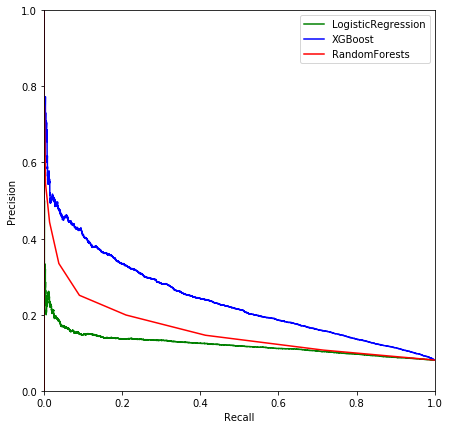

In [141]:
def plot_precision_recall_curve(re, pr, color, label=None): 
    plt.plot(re, pr, color, label=label) 
    #plt.plot([1, 0], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

plt.figure(figsize=(7,7))
plt.plot(re_lg, pr_lg, color='g', label='LogisticRegression')
plot_precision_recall_curve(re_xgb, pr_xgb, 'b', 'XGBoost')
plot_precision_recall_curve(re_rf, pr_rf, 'r', 'RandomForests')         
plt.legend(loc="bottom right")
plt.show()

##### 4.4.2 ROC

ROC curve plots true positive rate vs false positive rate. A random guesser would have a ROC curve the same as the diagonal. The further aways the curve is from the diagonal, the better the classifier is at differentiating the two classes. According to the ROC curves below, logistic regression and random forests algorithms perform very similarily, and xgboost algorithm is the best among the three.

In [138]:
fp_lg, tp_lg, th_lg = roc_curve(test_y, lg_pred)  
fp_xgb, tp_xgb, th_xgb = roc_curve(test_y, xgb_pred)  
fp_rf, tp_rf, th_rf = roc_curve(test_y, rf_pred)  

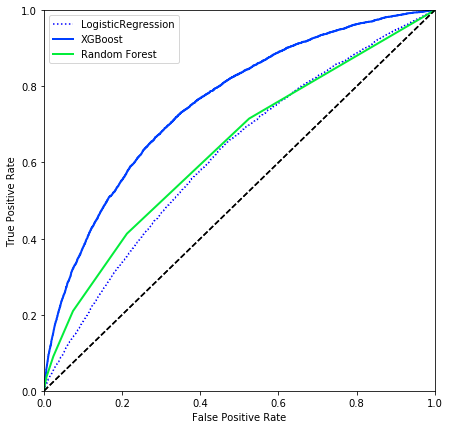

In [140]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure(figsize=(7,7))
plt.plot(fp_lg, tp_lg, "b:", label="LogisticRegression")
plot_roc_curve(fp_xgb, tp_xgb, "XGBoost")
plot_roc_curve(fp_rf, tp_rf, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [144]:
roc_lg = roc_auc_score(test_y, lg_pred)
roc_rf = roc_auc_score(test_y, rf_pred)
roc_xgb = roc_auc_score(test_y, xgb_pred)
print('The ROC AUC for LogisticRegression is:', roc_lg)
print('The ROC AUC for RandomForest is:', roc_rf)
print('The ROC AUC for XGBoost is:', roc_xgb)

The ROC AUC for LogisticRegression is: 0.6180873244196161
The ROC AUC for RandomForest is: 0.6357274845885186
The ROC AUC for XGBoost is: 0.7550515927100443


### 5. Retrospective

This notebook demonstrates a general process of solving a prediction problem with machine learning. Some details are omitted for simplicity. For example, I could apply different imputation methods for missing values according to their patterns. Depending on the needs, selecting models using cross-validation and fine tune hyperparameters can be necessary.